In [130]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
import random
from skimage import io
import heapq

import networkx as nx

#plt.rcParams['text.usetex'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

Circular Track Sanity Check

Separate representation of the board from the logic.
Each lane is a 1D NaSch sim

In [131]:
class Lane:
    # a 1D Nagel-Schreckenberg simulation using Cars
    def __init__(self, name, road_length = 100, car_density = 0.7, max_speed = 5, prob_slow = 0.2, anchor = 50, direction = 'NS') -> None:
        
        self.name = name
        
        self.road_length = road_length
        # TODO: max_speed for a specific Lane

        self.direction = direction
        self.anchor = anchor
        
        # TODO: arrival_rate based on empirical prior
        self.curr_time  = 0

        self.representation = np.full(self.road_length, -1, dtype=int)
        self.previous_states = []

        # Init cars or road based on Lane params // speeed limits vary by lane
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        self.cars = []
        car_idxs = np.random.choice(
                range(self.road_length),
                size=int(round(car_density * self.road_length)),
                replace=False)

        for i in car_idxs:
            velocity_i = np.random.randint(0 , self.max_speed + 1)
            new_car = Car(position = i,
                        velocity = velocity_i,
                        max_speed = self.max_speed, 
                        prob_slow = self.prob_slow)
            heapq.heappush(self.cars, new_car)

    def update(self, graph):
        # Calculate the next position
        cars_ = sorted(self.cars)

        if len(cars_) > 1:

            for i, car in enumerate(cars_):
                # Distance to nearest car, or other object
                next_car  = cars_[(i + 1) % len(self.cars)]
                dist = (next_car.position - car.position) % self.road_length

                car.calc_next_velocity(dist)

        elif len(cars_) == 1:
            MAX = self.road_length
            cars_[0].calc_next_velocity(MAX)

        else: 
            # do nothing
            return

        # set next_pos
        for car in self.cars:
            # Move along road, or pass to another Node
            car.update_position(max_length = self.road_length, 
                                curr_node  = self,
                                graph      = graph)

        # Update representation for visualization
        # At each step for space-time
        self.set_representation()

    def update_time(self, sim_time):
        self.curr_time = sim_time

    ### Utils

    def nearest_car(self, position = 5):
        
        car_pos = [car.position for car in self.cars]
        car_pos = np.array(car_pos)

        idx = (np.abs(car_pos - position)).argmin()

        return car_pos[idx]

    ########## Visualization

    def set_representation(self):
        # get positions of cars, set index
        new_representation = np.full(self.road_length, -1, dtype=int)

        for car in self.cars:
            car_idx = car.position
            car_vel = car.velocity

            new_representation[car_idx] = car_vel

        self.previous_states.append(new_representation)
        self.representation = new_representation

        return

    def show_lane(self, axs = False):

        prev = self.previous_states

        if axs: 
            for i in range(len(prev)):
                # Filter out empty cells
                y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
                
                t = [i]*len(y_cars)
                t_points = list(zip([0]*len(y_cars), y_cars))

                c = prev[i][prev[i] != -1]

                # Make colorbar a func of speed
                a = axs.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')
                axs.set_yticks(range(len(prev)))
                axs.set_axis_off()
                axs.set_title(f'{self.anchor} {self.direction} after {self.curr_time} Steps')

                plt.gca().invert_yaxis()
        else:
            fig, ax  = plt.subplots(1,1, figsize= (3,3))
            for i in range(len(prev)):
                # Filter out empty cells
                y_cars = np.arange(0, len(prev[i]))[prev[i] != -1]
                
                t = [i]*len(y_cars)
                t_points = list(zip([0]*len(y_cars), y_cars))

                c = prev[i][prev[i] != -1]

                # Make colorbar a func of speed
                a = ax.scatter(y_cars, t, c = c, alpha = 0.6, marker = 'o', cmap='bone_r')

            ax.set_yticks(range(len(prev)))
            ax.set_axis_off()
            ax.set_title(f'{self.anchor} {self.direction} after {self.curr_time} Steps')

            plt.gca().invert_yaxis()
        
        return 

    

class Environment:
    # Variables of sim and current time
    def __init__(self, road_length, car_density, max_speed, prob_slow, n_lanes = 1) -> None:
        self.curr_time = 0

        self.lanes = []

        if n_lanes > 1:

            anchors = np.random.choice(np.arange(0,road_length), size = n_lanes, replace = False)
            directions = np.random.choice(["NS", "EW", "WE", "SN"], size = n_lanes, replace = True)

            for i in range(n_lanes):
                new_lane = Lane(self, 
                                road_length = road_length, 
                                car_density = car_density, 
                                max_speed = max_speed, 
                                prob_slow = prob_slow, 
                                anchor = anchors[i], 
                                direction = directions[i])
                self.lanes.append(new_lane)

        else: 
            new_lane = Lane(self, 
                                road_length = road_length, 
                                car_density = car_density, 
                                max_speed = max_speed, 
                                prob_slow = prob_slow, 
                                anchor = 50, 
                                direction = "NS")
            self.lanes.append(new_lane)

        self.env_rep = np.full((road_length, road_length), -2)

    def update(self):
        for lane in self.lanes:
            # update 
            lane.update(self)
            lane.update_time(self.curr_time)
        # increment time
        self.curr_time += 1


    # TODO: invert SN and WE
    def update_representation(self):
        new_rep = self.env_rep.copy()

        for lane in self.lanes:
            if lane.direction == 'NS' or lane.direction == 'SN' :
                new_rep[:, lane.anchor] = lane.representation
            elif lane.direction == 'EW' or lane.direction == 'WE' :
                new_rep[lane.anchor, :] = lane.representation

        self.env_rep = new_rep

        return self.env_rep

    def show_board(self, ax = False):

        self.update_representation()
        
        if ax:
            return ax.imshow(self.env_rep, cmap = 'gray_r')
        else:
            return plt.imshow(self.env_rep, cmap = 'gray_r')
 
class Car:
    def __init__(self, position, velocity, max_speed, prob_slow) -> None:
        self.position = position
        self.velocity = velocity

        self.next_velocity = velocity
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        self.history = []

    def __lt__(self, other):
        return self.position < other.position

    def __repr__(self) -> str:
        return f'Car at {self.position} with {self.velocity} cells/step'   

    def calc_next_velocity(self, dist):

        # Acceleration
        if self.velocity < self.max_speed:
            self.next_velocity = self.velocity + 1

        # Slow down
        if self.next_velocity >= dist:
            self.next_velocity = dist - 1

        # Random Transition Probability
        if self.next_velocity > 0:
            gamble = np.random.random() < self.prob_slow
            if gamble:
                self.next_velocity -= 1
    
    def update_position(self, max_length , curr_node = None, graph = None ,loop = False):

        
        self.velocity = self.next_velocity


        if loop:
            self.position += self.velocity
            self.position %= max_length
        else:
            # for graph implementation 
            proposed_position = self.position + self.velocity

            sim_graph =  graph.graph

            if proposed_position >= max_length:
                
                # node car is at
                car_node = curr_node.name

                # get a list of outgoing edges from current node
                out_edges = list(sim_graph.out_edges(car_node))

                # get list of target nodes
                potential_nodes = [i[1] for i in out_edges]

                # if just one node to move to, move onto it
                # TODO: this is the traffic light

                if len(potential_nodes) >= 1:
                    # pop off the current lane
                    curr_node.cars.remove(self)

                    # push onto target node
                    target_node = np.random.choice(potential_nodes)
                    # classes are stored as data, so get it
                    target_class = sim_graph.nodes[target_node]['data']

                    #push onto new node, with position 
                    # find position on new lane
                    proposed_new_pos = (proposed_position - max_length) + 1

                    if self.velocity < 0:
                        print(proposed_new_pos)
                        print(self.velocity)


                    # is the location free? 
                    while proposed_new_pos == target_class.nearest_car(proposed_new_pos) and proposed_new_pos >= -1:
                        proposed_new_pos -= 1

                        
                    # no spots found, stay here
                    if proposed_new_pos <= -1:
                        # putt back into lane
                        self.position = max_length
                        curr_node.cars.append(self)
                        return

                    # if its empty, push it
                    self.position = proposed_new_pos
                    target_class.cars.append(self)

                else: 
                    # choose a random thing
                    #print('nowhere to go', car_node)
                    pass
            else:
                self.position += self.velocity



        self.history.append(self.velocity)

In [132]:

# total number of cars over time in sim :: 
# in loop vs not in loop

In [179]:
class GraphSim:
    def __init__(self) -> None:

        self.curr_time  = 0
        self.graph = nx.DiGraph()

        self.lanes = [Lane('hien'),
                      Lane('neumann', car_density = 0.1),
                      Lane('ubahn', car_density = 0.1)]


        self.terminals = []



    
    def wire_graph(self):
        for lane in self.lanes:
            self.graph.add_node(lane.name, data = lane)

        self.graph.add_edge('hien', 'neumann')
        self.graph.add_edge('hien', 'ubahn')

        # add Terminal nodes to Nodes without outgoing edges
        self.add_terminals()

    def add_terminals(self):

        for node in list(self.graph.nodes):
            outgoing = list(self.graph.out_edges(node))

            if len(outgoing) == 0:
                # create a Terminal to hold exited cars
                new_terminal = Terminal()

                self.terminals.append(new_terminal)
                new_terminal.name = f'Terminal {len(self.terminals)}'

                self.graph.add_node(new_terminal.name, data = new_terminal)
                self.graph.add_edge(node, new_terminal.name)



    def update(self):
        for lane in self.lanes:
            # update 
            lane.update(self)
            lane.update_time(self.curr_time)
        # increment time
        self.curr_time += 1

    def run(self, sims = 1000):
        for i in range(sims):
            self.update()

    ##### Visualization

    def show_graph(self):
        try:
            sizes = [len(g.graph.nodes[i]['data'].cars)*50 for i in self.graph.nodes]
            nx.draw_networkx(self.graph, node_size = sizes)
        except:
            nx.draw_networkx(self.graph)

        
        

In [180]:
class Node:
    def __init__(self) -> None:
        # Collects Cars for data analysis
        self.cars = []
        self.name = ''


class Terminal(Node):
    def __init__(self) -> None:
        super().__init__()

    def nearest_car(self, proposed_pos):
        MAX = 10000
        return MAX


[0, 0]
[50, 40]


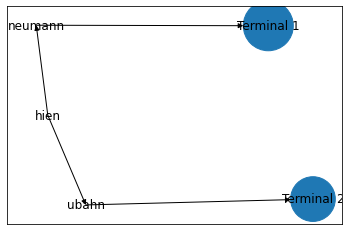

In [182]:
# get cars to flow from hien to ubahn to neumann

g = GraphSim()


g.wire_graph()

print([len(lane.cars) for lane in g.terminals])

g.run()

print([len(lane.cars) for lane in g.terminals])

# make sure cars are not being dropped
#hist = np.array(g.lanes[2].previous_states)

#np.sum(hist > -1, axis = 1).shape


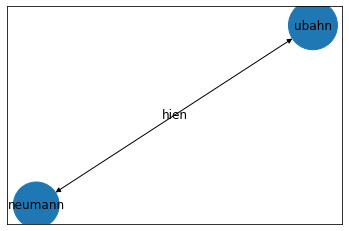

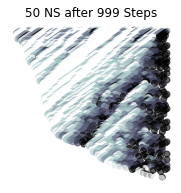

In [136]:
g.show_graph()

g.lanes[0].show_lane()

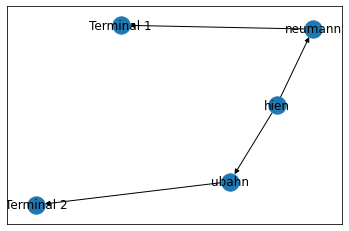

In [137]:
# add functionality to collect at end node if no connections

terminals = []

for node in list(g.graph.nodes):
    outgoing = list(g.graph.out_edges(node))

    if len(outgoing) == 0:
        # create a Terminal to hold exited cars
        new_terminal = Terminal()

        terminals.append(Terminal)
        new_terminal.name = f'Terminal {len(terminals)}'

        g.graph.add_node(new_terminal.name, data = new_terminal)
        g.graph.add_edge(node, new_terminal.name)


nx.draw_networkx(g.graph)

In [142]:
class Generator(Node):
    def __init__(self, arrival_rate = 10) -> None:
        super().__init__()

        self.arrival_rate = arrival_rate
        self.curr_time = 0

        self.position = 0

        self.p = self.arrival_rate / 60

    
    # generate a Car, and push it onto the connected Node
    def generate_car(self):

        # at each step
        if random.random() < self.p:

            new_car = Car(position = 0, 
                        velocity = np.random.randint(1,5),
                        max_speed = 5,
                        prob_slow= 0.3
                        )

            self.cars.append(new_car)

In [143]:
g = Generator()

In [144]:
for i in range(100):
    g.generate_car()

23